# Running 3-label classification models for the RuBisCO combined dataset, Not binary
## For the 3-labels, the `high_activity` is defined as 10x the threshold for activity (for large dataset) & 10x the activity of inactive_mutant (for mutant datasets)

In [1]:
import torch
import esm
import pickle
import random
from collections import Counter
from tqdm import tqdm
from datetime import datetime
from Bio import AlignIO, SeqIO
import plotly.express as px

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.preprocessing import label_binarize

In [2]:
def read_fasta_to_df(fasta_file, seq_header):   # We are going to ignore/remove all the other info like name and stuff from the fasta, just the id
    df = pd.DataFrame.from_records([item.__dict__ for item in SeqIO.parse(fasta_file, format='fasta')])
    df[seq_header] = df.apply(lambda x: ''.join(x['_seq']), axis=1)
    df = df.drop(columns=['_seq', 'name', 'description', 'dbxrefs', 'annotations', '_per_letter_annotations', 'features'])
    return(df)

In [3]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

def make_tSNE(input_df, embedding_col, id_col, perplexity=30):
    cosine_dist_matrix = pairwise_distances(np.stack(input_df[embedding_col].values), metric="cosine")
    tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=perplexity)
    tsne_out = tsne.fit_transform(cosine_dist_matrix)

    df_tsne = pd.DataFrame(tsne_out, columns=['Dim1', 'Dim2'])
    df_tsne['LSU_SSU_id'] = input_df[id_col].to_list()
    df_tsne = df_tsne.fillna(0)

    df_out = pd.merge(input_df, df_tsne, on=[id_col])

    return(df_out)

## Preparing the data

In [4]:
large_dataset = pd.read_pickle("/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/large_assay_dataset_wco2_wiptg_bimodal_activity_threshold.pkl")
norm2_threshold_log10 = 1.966
large_dataset['activity_3_label'] = large_dataset['log10_Norm_2'].apply(lambda x: 0 if x < norm2_threshold_log10 else (2 if x > norm2_threshold_log10 + 1.0 else 1))
large_dataset = large_dataset[["LSU_id", "SSU_id", "lsu_seq", "ssu_seq", "activity_binary", "activity_3_label"]]

In [5]:
mutant_dataset = pd.read_pickle("/home/kaustubh/RuBisCO_ML/ESM_LoRA/data/form_III_IB_anc_variants_binary_activity_only_wrt_inactive_variant.pkl")
mutant_dataset.rename(columns={"activity_binary_wrt_inactive_Anc": "activity_binary"}, inplace=True)

### The current measure for the high activity = 10 x mean_reading for the inactive Ancestor

In [6]:
High_activity_formIII_mutants = ['Anc367_mutant_15',
 'Anc367_mutant_20',
 'Anc367_mutant_38',
 'Anc367_mutant_1',
 'Anc367_mutant_16',
 'Anc367_mutant_25',
 'Anc367_mutant_27',
 'Anc367_mutant_34',
 'Anc367_mutant_40',
 'Anc367_mutant_46',
 'Anc366',
 'Anc393_mutant_12',
 'Anc393_mutant_15',
 'Anc393_mutant_16',
 'Anc393_mutant_19',
 'Anc393_mutant_28',
 'Anc393_mutant_33',
 'Anc393_mutant_43',
 'Anc393_mutant_47',
 'Anc393_mutant_26',
 'Anc393_mutant_39',
 'Anc393_mutant_40',
 'Anc393_mutant_44',
 'Anc365']

Low_activity_Anc510_mutants = [
'Anc510_mutant_cluster_56',
'Anc510_mutant_cluster_78',
'Anc510_mutant_cluster_95',
'Anc510_mutant_cluster_7',
'Anc510_mutant_cluster_14'
]

In [7]:
mutant_dataset['activity_3_label'] = mutant_dataset.apply(lambda x: 0 if x['activity_binary'] == 0 else (2 if x['activity_binary'] == 1 and x['LSU_id'] in High_activity_formIII_mutants else 1), axis=1)
mutant_dataset['activity_3_label'] = mutant_dataset.apply(lambda x: 2 if x['activity_binary'] == 1 and x['LSU_id'].startswith("Anc5") and x['LSU_id'] not in Low_activity_Anc510_mutants else x['activity_3_label'], axis=1)

In [8]:
combined_dataset = pd.concat([large_dataset, mutant_dataset], ignore_index=True)
combined_dataset = combined_dataset[combined_dataset['LSU_id'] != "SUMO"]
combined_dataset = combined_dataset[combined_dataset['LSU_id'] != "DEAD"]

In [9]:
combined_dataset['LSU_SSU_id'] = combined_dataset.apply(lambda x: x['LSU_id'] + "-" + x['SSU_id'] if pd.notna(x['SSU_id']) else x['LSU_id'] + "-none", axis=1)
combined_dataset['LSU_SSU_seq'] = combined_dataset.apply(lambda x: x['lsu_seq'] + x['ssu_seq'] if pd.notna(x['ssu_seq']) else x['lsu_seq'], axis=1)

## Building embeddings

In [10]:
pretrained_arg = esm.pretrained.esm2_t33_650M_UR50D() ## For ESM-1b: `esm1_t34_670M_UR50S`; ESM-2: `esm2_t33_650M_UR50D()`
layers = 33 ## For ESM-1b: 34; ESM-2: 33

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()
model = model.to(torch.device('cuda:0'))

def compute_embedding(key, value):
    inp = [(key, value)]
    batch_labels, batch_strs, batch_tokens = batch_converter(inp)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(torch.device('cuda:0'))
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[layers])
        
    token_representations = results["representations"][layers]
    # return token_representations[0, 0]
    return token_representations[0, 1 : batch_lens[0] - 1].mean(0)


combined_dataset['lsu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['LSU_id'], x['lsu_seq']).cpu().numpy() if pd.notna(x['lsu_seq']) else np.nan, axis=1)
combined_dataset['ssu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['SSU_id'], x['ssu_seq']).cpu().numpy() if pd.notna(x['ssu_seq']) else np.nan, axis=1)
combined_dataset['lsussu_esm'] = combined_dataset.apply(lambda x: compute_embedding(x['LSU_SSU_id'], x['LSU_SSU_seq']).cpu().numpy() if pd.notna(x['LSU_SSU_seq']) else np.nan, axis=1)

In [11]:
## Generating a weighted average of the LSU and SSU embeddings -- weighted based on the length of the LSU & SSU sequence

combined_dataset['lsu_ssu_weighted_esm'] = combined_dataset.apply(lambda x: np.average((x['lsu_esm'], x['ssu_esm']), axis=0, weights=[
    float(len(x['lsu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq'])), float(len(x['ssu_seq']))/float(len(x['lsu_seq']) + len(x['ssu_seq']))
    ]) 
    if pd.notna(x['ssu_seq']) else x['lsu_esm'], axis=1)

#### Removing the duplicate entries that are the Anc365, Anc366, Anc367, Anc393 & Anc509 entries from the combined dataset

In [12]:
repeat_entries = ["Anc365", "Anc366", "Anc367", "Anc393", "Anc509"]
combined_dataset = combined_dataset[~combined_dataset['LSU_id'].isin(repeat_entries)]

## Preparing the data for training

In [13]:
Xs = []
ys = []
data = []
headers = []

for i, row in combined_dataset.iterrows():
    header = row['LSU_SSU_id']
    headers.append(header)
    sequence = row['LSU_SSU_seq']
    data.append((header, sequence))
    ys.append(row['activity_3_label'])    ## Change based on what is to be used as a label
    Xs.append(row['lsu_ssu_weighted_esm'])    ## Change based on what is to be used as a sequence embedding

## Training block

In [15]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svc_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfc_grid = {
    'n_estimators' : [100],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [2, 10],
    'min_samples_leaf': [1, 4]
}
lgr_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'max_iter': [100, 500, 1000],
    'l1_ratio': [0.5],
    'multi_class': ['multinomial']
}

# Training ONLY on the large dataset & testing on the mutant dataset -- like the Rhodopsin paper

## Creating Training and Test set

### Generating the corresponding Train & Test dataset

In [14]:
test_indices_divided = [i for i, x in enumerate(headers) if x.startswith("Anc")]
train_indices_divided = [i for i, x in enumerate(headers) if i not in test_indices_divided]

Xs_train_divide = [Xs[i] for i in train_indices_divided]
Xs_test_divide = [Xs[i] for i in test_indices_divided]
ys_train_divide = [ys[i] for i in train_indices_divided]
ys_test_divide = [ys[i] for i in test_indices_divided]

### Training the model ONLY on the large dataset

In [16]:
cls_list = [KNeighborsClassifier, SVC, RandomForestClassifier, LogisticRegression]
param_grid_list = [knn_grid, svc_grid, rfc_grid, lgr_grid]
result_list_divided = []
grid_list_divided = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(),
        param_grid = param_grid,
        scoring = 'f1_macro',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train_divide, ys_train_divide)
    result_list_divided.append(pd.DataFrame.from_dict(grid.cv_results_))    
    grid_list_divided.append(grid)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


<class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 24 candidates, totalling 120 fits
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/kaustubh/miniforge3/envs/rubisco_regressor/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it w

In [17]:
grid_list_divided

[GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [15, 30], 'n_neighbors': [5, 10],
                          'p': [1, 2], 'weights': ['uniform', 'distance']},
              scoring='f1_macro', verbose=1),
 GridSearchCV(estimator=SVC(), n_jobs=-1,
              param_grid={'C': [0.1, 1.0, 10.0], 'degree': [3],
                          'gamma': ['scale'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              scoring='f1_macro', verbose=1),
 GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 4],
                          'min_samples_split': [2, 10], 'n_estimators': [100]},
              scoring='f1_macro', verbose=1),
 GridSearchCV(estimator=Lo

## Testing the trained model 


KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, p=1,
                     weights='distance')


Accuracy: 0.746268656716418
Confusion Matrix:
 [[32 14  0]
 [ 9 23  5]
 [14  9 95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.70      0.63        46
           1       0.50      0.62      0.55        37
           2       0.95      0.81      0.87       118

    accuracy                           0.75       201
   macro avg       0.68      0.71      0.69       201
weighted avg       0.78      0.75      0.76       201

Multiclass ROC AUC (macro, OVR): 0.8242573677699724

SVC(C=10.0, kernel='linear')
Accuracy: 0.7213930348258707
Confusion Matrix:
 [[35 11  0]
 [17 15  5]
 [19  4 95]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.76      0.60        46
           1       0.50      0.41      0.45        37
           2       0.95      0.81      0.87       118

    accuracy                           0.72       201
   macro avg       0.65      0.66      0.64     

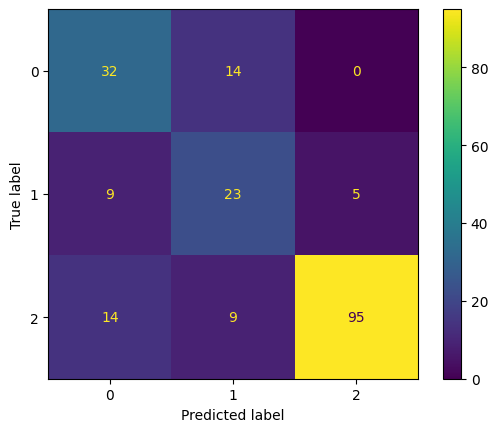

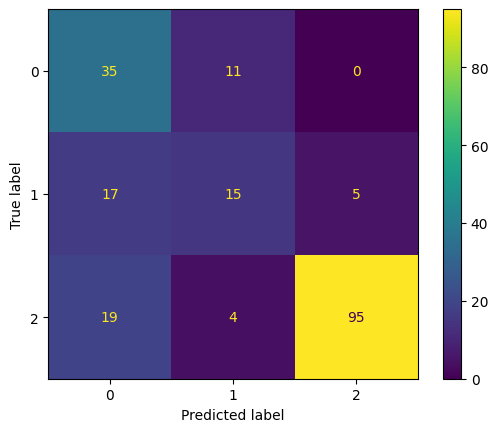

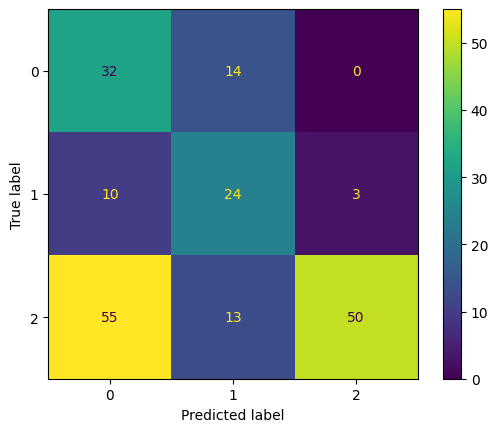

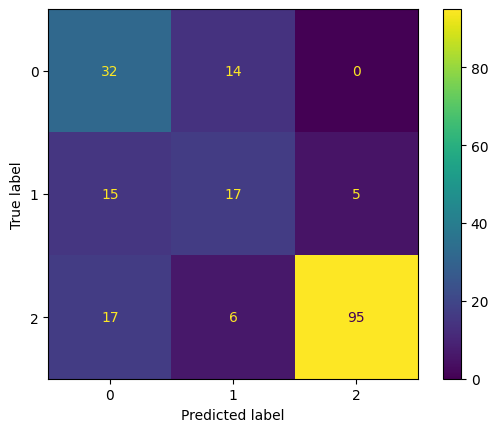

In [18]:
num_classes = 3

for i, grid in enumerate(grid_list_divided):
    print()
    print(grid.best_estimator_)
    best_model_divided = grid.best_estimator_

    # Predictions
    preds = best_model_divided.predict(Xs_test_divide)
    accuracy = accuracy_score(ys_test_divide, preds)
    cm = confusion_matrix(ys_test_divide, preds)
    # tn, fp, fn, tp = cm.ravel()
    ConfusionMatrixDisplay(cm).plot()
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(ys_test_divide, preds))


    if hasattr(best_model_divided, "predict_proba"):
        y_prob = best_model_divided.predict_proba(Xs_test_divide)
        y_test_bin = label_binarize(ys_test_divide, classes=sorted(set(ys_test_divide)))

        try:
            roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
            print("Multiclass ROC AUC (macro, OVR):", roc_auc)
        except ValueError as e:
            print("ROC AUC could not be computed:", e)

In [ ]:
## May 06, 2025 (~ 1:00pm CST) -- Was initially testing the test_divide on the `best_model` instead of the `best_model_divided`

timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"/home/kaustubh/RuBisCO_ML/regressor_models/models/classifier_model/"

## Saving the best model
import pickle
model_name = "KNN"

best_model_divide = grid_list_divided[0].best_estimator_
best_model_divide_preds = best_model_divide.predict(Xs_test_divide)
with open(f"{output_dir}/{model_name}_{timestamp_str}_3label_classifier_best_model_large_mutant_divide.pkl", "wb") as f:
    pickle.dump(best_model_divide, f)

Synthesis: The KNN classifier has the best accuracy across the 3 labels & the 4 classifiers. \
Let's check the performance only on the Form-III variants

### Assess the incorrect predictions

In [25]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

def make_tSNE(input_df, embedding_col, id_col, perplexity=30):
    cosine_dist_matrix = pairwise_distances(np.stack(input_df[embedding_col].values), metric="cosine")
    tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=perplexity)
    tsne_out = tsne.fit_transform(cosine_dist_matrix)

    df_tsne = pd.DataFrame(tsne_out, columns=['Dim1', 'Dim2'])
    df_tsne['LSU_SSU_id'] = input_df[id_col].to_list()
    df_tsne = df_tsne.fillna(0)

    df_out = pd.merge(input_df, df_tsne, on=[id_col])

    return(df_out)

In [24]:
All_inaccurate_prediction_ids = []
for i in range(len(ys_test_divide)):
    if ys_test_divide[i] != best_model_divide_preds[i]:
        All_inaccurate_prediction_ids.append(headers[test_indices_divided[i]])
        print(f"LSU_SSU_id: {headers[test_indices_divided[i]]}")
        print(f"label: {ys_test_divide[i]}; pred: {best_model_divide_preds[i]}")
        print()

LSU_SSU_id: Anc367_mutant_15-none
label: 2; pred: 0

LSU_SSU_id: Anc367_mutant_20-none
label: 2; pred: 0

LSU_SSU_id: Anc367_mutant_26-none
label: 1; pred: 0

LSU_SSU_id: Anc367_mutant_38-none
label: 2; pred: 0

LSU_SSU_id: Anc393_mutant_12-none
label: 2; pred: 1

LSU_SSU_id: Anc393_mutant_13-none
label: 0; pred: 1

LSU_SSU_id: Anc393_mutant_15-none
label: 2; pred: 1

LSU_SSU_id: Anc393_mutant_16-none
label: 2; pred: 1

LSU_SSU_id: Anc393_mutant_19-none
label: 2; pred: 1

LSU_SSU_id: Anc393_mutant_21-none
label: 0; pred: 1

LSU_SSU_id: Anc393_mutant_25-none
label: 0; pred: 1

LSU_SSU_id: Anc393_mutant_28-none
label: 2; pred: 1

LSU_SSU_id: Anc393_mutant_31-none
label: 0; pred: 1

LSU_SSU_id: Anc393_mutant_33-none
label: 2; pred: 1

LSU_SSU_id: Anc393_mutant_36-none
label: 0; pred: 1

LSU_SSU_id: Anc393_mutant_43-none
label: 2; pred: 0

LSU_SSU_id: Anc393_mutant_46-none
label: 1; pred: 0

LSU_SSU_id: Anc393_mutant_47-none
label: 2; pred: 1

LSU_SSU_id: Anc367_mutant_1-none
label: 2; pre

In [26]:
combined_dataset

,LSU_id,SSU_id,lsu_seq,ssu_seq,activity_binary,activity_3_label,LSU_SSU_id,LSU_SSU_seq,lsu_esm,ssu_esm,lsussu_esm,lsu_ssu_weighted_esm
0,330,603,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQAYQQSQKTGTFSYLPPMTAEQVTAQIQYCLEKGWAICIEHTEPE...,0,0,330-603,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.014397051, 0.10166579, 0.0043634777, -0.050...","[0.026688656, 0.030369852, -0.020122623, -0.06...","[0.0368665970481332, 0.024569510615820498, -0...."
1,330,605,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQATQQSSKTSSFSAAAERVLAQIGHCLRKGCVICIEHTPSMAPRF...,0,0,330-605,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.008877339, 0.06041656, 0.025597723, -0.0425...","[0.05942161, 0.018016469, -0.026957061, -0.078...","[0.03589691068645161, 0.015382275132849664, -0..."
2,330,607,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQTTQATAATASFPAEERMLAQLGHCLRKGCVICIEHTAAMQPRYT...,0,0,330-607,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.009472291, 0.07615884, -0.0067445133, -0.03...","[0.03671648, 0.021743942, -0.027661677, -0.064...","[0.03607328885072281, 0.01854132752244671, -0...."
3,330,E1,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MAEMQDYKQSLKYETFSYLPPMNAERIRAQIKYAIAQGWSPGIEHV...,0,0,330-E1,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.041855287, 0.06014329, 0.05297826, 0.036349...","[0.02989232, 0.022772914, -0.019962031, -0.054...","[0.042744903660872406, 0.01576484663083273, -0..."
4,330,E2,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,MQVWPILNLKKYETLSYLPPLTTDQLARQVDYLLNNKWVPCLEFET...,0,0,330-E2,MAEDRLVATYHIEDGADLEKAAQQIAAEQSTGTWTEVPTETEELRE...,"[0.04298955, 0.0035607752, -0.019734506, -0.08...","[0.016487531, 0.109111644, 0.015157939, 0.0581...","[0.0492836, 0.015711924, -0.024560945, -0.0596...","[0.036756760374879745, 0.02838440215923818, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2911,Anc510_mutant_cluster_95,SSU_510,MQTQTQTKAGYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,1,Anc510_mutant_cluster_95-SSU_510,MQTQTQTKAGYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,"[0.011621219, 0.084632024, -0.01828115, -0.036...","[0.036390934, 0.08527322, 0.016811753, 0.01215...","[0.040780246, 0.068368085, -0.031451806, -0.02...","[0.015517177170446253, 0.08473287621703844, -0..."
2912,Anc510_mutant_cluster_96,SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,2,Anc510_mutant_cluster_96-SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,"[0.0095866835, 0.08347685, -0.0150982225, -0.0...","[0.036390934, 0.08527322, 0.016811753, 0.01215...","[0.041344862, 0.06536592, -0.03095076, -0.0251...","[0.013808740298882814, 0.08375980348643884, -0..."
2913,Anc510_mutant_cluster_97,SSU_510,MQTQTQTKAMYQAGVKDYRETYYTPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,2,Anc510_mutant_cluster_97-SSU_510,MQTQTQTKAMYQAGVKDYRETYYTPDYTPKDTDILAAFRVTPQPGV...,"[0.010069732, 0.08149717, -0.014407639, -0.036...","[0.036390934, 0.08527322, 0.016811753, 0.01215...","[0.04115237, 0.06323461, -0.030103918, -0.0249...","[0.014203753343834315, 0.08209023857623425, -0..."
2914,Anc510_mutant_cluster_98,SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,MQTLPKERRFETFSYLPPLSDEQIAKQIQYILDQGWIPAIEFSESS...,1,2,Anc510_mutant_cluster_98-SSU_510,MQTQTQTKAMYQAGVKDYRETYYDPDYTPKDTDILAAFRVTPQPGV...,"[0.009374116, 0.08369485, -0.013429356, -0.033...","[0.036390934, 0.08527322, 0.016811753, 0.01215...","[0.04107086, 0.06535961, -0.028042639, -0.0221...","[0.013629654949972394, 0.08394346869620628, -0..."


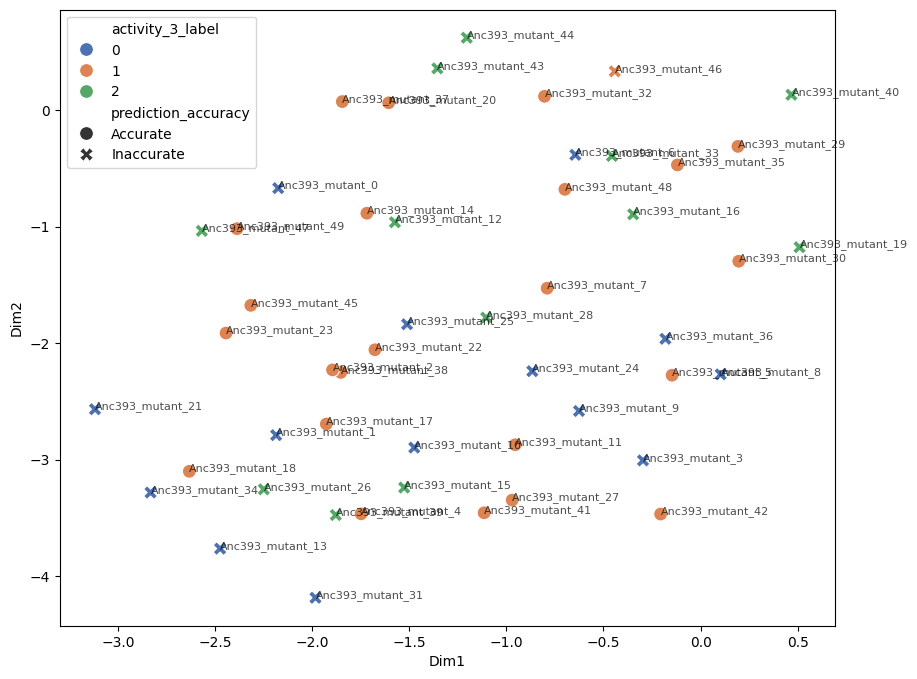

In [29]:
tsne_anc393_variants_df = make_tSNE(combined_dataset.query('LSU_id.str.startswith("Anc393") or LSU_id == "Anc365"'), "lsu_ssu_weighted_esm", "LSU_SSU_id", perplexity=30)
tsne_anc393_variants_df['prediction_accuracy'] = tsne_anc393_variants_df['LSU_SSU_id'].apply(lambda x: "Inaccurate" if x in All_inaccurate_prediction_ids else "Accurate")

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_anc393_variants_df, x="Dim1", y="Dim2", hue="activity_3_label", style="prediction_accuracy", s=100, palette="deep")

for i in range(len(tsne_anc393_variants_df)):
    plt.annotate(tsne_anc393_variants_df['LSU_id'].iloc[i], (tsne_anc393_variants_df['Dim1'].iloc[i], tsne_anc393_variants_df['Dim2'].iloc[i]), fontsize=8, alpha=0.7)

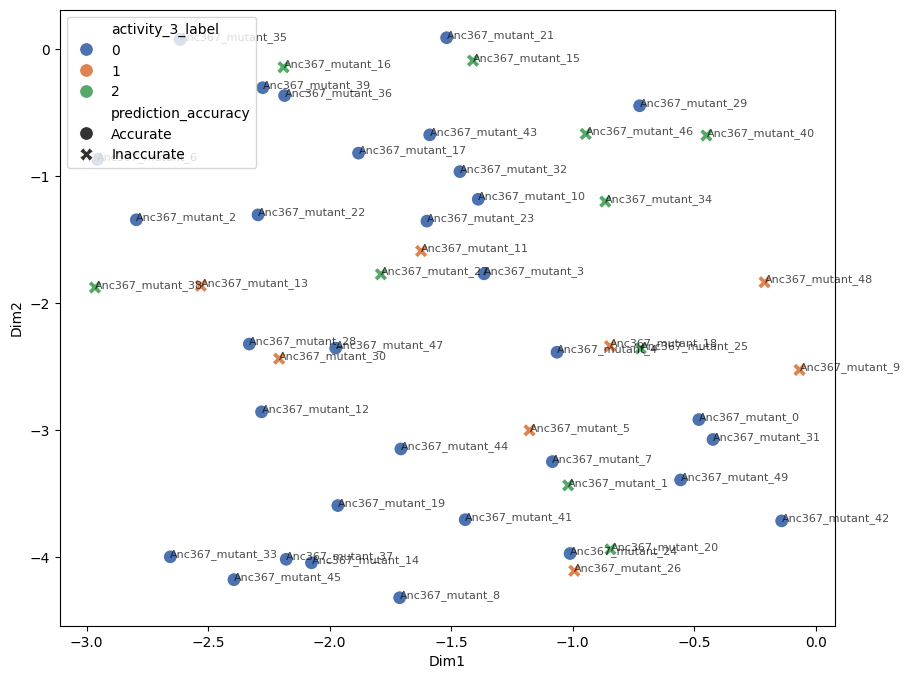

In [30]:
tsne_anc367_variants_df = make_tSNE(combined_dataset.query('LSU_id.str.startswith("Anc367") or LSU_id == "Anc366"'), "lsu_ssu_weighted_esm", "LSU_SSU_id", perplexity=30)
tsne_anc367_variants_df['prediction_accuracy'] = tsne_anc367_variants_df['LSU_SSU_id'].apply(lambda x: "Inaccurate" if x in All_inaccurate_prediction_ids else "Accurate")

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_anc367_variants_df, x="Dim1", y="Dim2", hue="activity_3_label", style="prediction_accuracy", s=100, palette="deep")

for i in range(len(tsne_anc367_variants_df)):
    plt.annotate(tsne_anc367_variants_df['LSU_id'].iloc[i], (tsne_anc367_variants_df['Dim1'].iloc[i], tsne_anc367_variants_df['Dim2'].iloc[i]), fontsize=8, alpha=0.7)

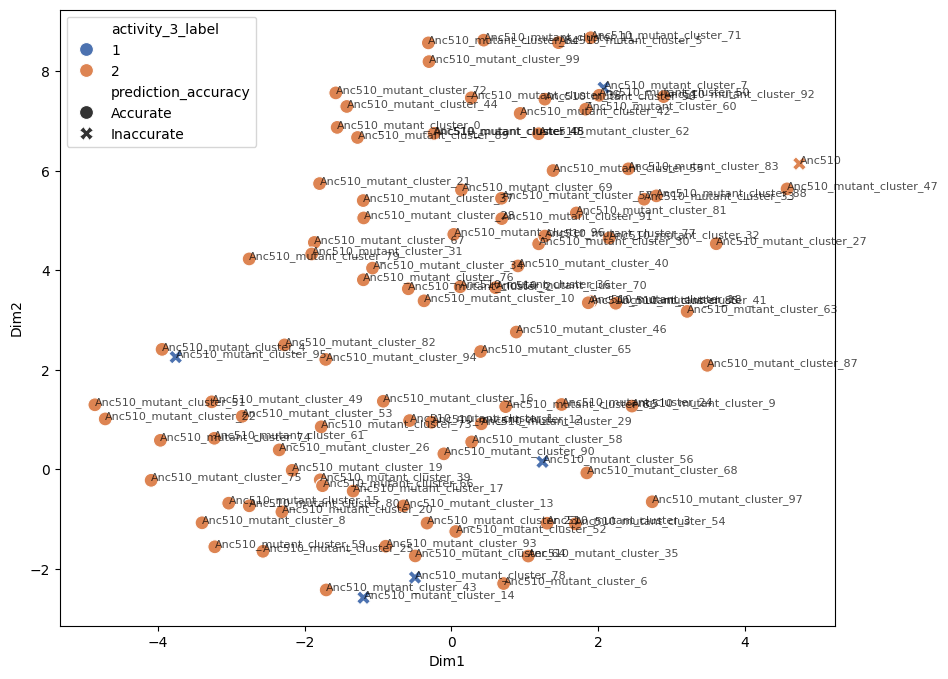

In [31]:
tsne_anc510_variants_df = make_tSNE(combined_dataset.query('LSU_id.str.startswith("Anc510") or LSU_id == "Anc509"'), "lsu_ssu_weighted_esm", "LSU_SSU_id", perplexity=30)
tsne_anc510_variants_df['prediction_accuracy'] = tsne_anc510_variants_df['LSU_SSU_id'].apply(lambda x: "Inaccurate" if x in All_inaccurate_prediction_ids else "Accurate")

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_anc510_variants_df, x="Dim1", y="Dim2", hue="activity_3_label", style="prediction_accuracy", s=100, palette="deep")

for i in range(len(tsne_anc510_variants_df)):
    plt.annotate(tsne_anc510_variants_df['LSU_id'].iloc[i], (tsne_anc510_variants_df['Dim1'].iloc[i], tsne_anc510_variants_df['Dim2'].iloc[i]), fontsize=8, alpha=0.7)

### Model is kinda shit -- not good at classifying the 3-labels